# Car pricing strategy

**An aim of the research** — develop a method for predicting the market price of cars:
1. Data pre-processing and model building with PySpark framework
2. Comparison of machine learning models efficiency and execution time
3. Application of following algorithms:
- Linear Regression
- Decision Tree
- Rendom Forest
- Gradient Boosted Tree
- Light Gradient Boosting

**An initial data**

The dataframe is extracted from the file `autos.csv`.

Since data pre-processing has not been carried out before, it is necessary to additionally perform Exploratory data analysis and Feature engineering.
 
The research is divided into four staps:
  1. Data overview
  2. Data pre-processing
  3. Exploratory data analysis
  4. Machine learning models  

### Step 1. Data overview

In [1]:
# main libraries
import pyspark
import lightgbm as lgb
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from collections import Counter
import warnings
import time

# dataframe spark profiling 
from pyspark.sql.types import *
import pyspark.sql.functions as func
from pyspark.sql.functions import isnull, isnan, when, col, mean, round
from pyspark.sql.functions import udf, countDistinct, count
from pyspark.sql.types import Row
from pyspark.sql import Window

# pandas dataframe operation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array

# modeling and evaluation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.functions import when, monotonically_increasing_id
from pyspark.sql import Row, functions as F
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from sklearn.metrics import log_loss
from pyspark.sql.functions import corr
import pyspark.sql.functions as fn 
from pyspark.sql.functions import rank, sum, col
from pyspark.sql import Window
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# set global parameters 
pd.set_option('precision', 2)
warnings.filterwarnings('ignore')
np.random.seed(777)

In [3]:
# initialize SparkSession for creating Spark DataFrame
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [4]:
# define path to directory
path1 = '/datasets/autos.csv'
path2 = 'C:/YandexPracticumProjects/Project_11_CarPricing_ML/autos.csv'

In [5]:
# read in 'autos.csv' 
try:
    df_origin = spark.read.csv(path1)
    df_origin = spark.read.option('header', True).csv(path1)
except:  
    df_origin = spark.read.csv(path2)
    df_origin = spark.read.option('header', True).csv(path2)

In [6]:
# type of data
type(df_origin)

pyspark.sql.dataframe.DataFrame

In [7]:
# show 5 observations in data
display(df_origin.toPandas().head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,None,1993,manual,0,golf,150000,0,petrol,volkswagen,None,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,None,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,None,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
# print out schema and count number of columns from data
len(df_origin.columns), df_origin.printSchema()

root
 |-- DateCrawled: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- VehicleType: string (nullable = true)
 |-- RegistrationYear: string (nullable = true)
 |-- Gearbox: string (nullable = true)
 |-- Power: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Kilometer: string (nullable = true)
 |-- RegistrationMonth: string (nullable = true)
 |-- FuelType: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- NotRepaired: string (nullable = true)
 |-- DateCreated: string (nullable = true)
 |-- NumberOfPictures: string (nullable = true)
 |-- PostalCode: string (nullable = true)
 |-- LastSeen: string (nullable = true)



(16, None)

### Step 2. Data pre-processing

In [9]:
# rename Target('Price') to 'label
df = df_origin.withColumnRenamed('Price', 'label')

In [10]:
# change data types in data
df = df.withColumn('label', df['label'].cast(IntegerType()))
df = df.withColumn('RegistrationYear', df['RegistrationYear'].cast(IntegerType()))
df = df.withColumn('Power', df['Power'].cast(IntegerType()))
df = df.withColumn('Kilometer', df['Kilometer'].cast(IntegerType()))
df = df.withColumn('RegistrationMonth', df['RegistrationMonth'].cast(IntegerType()))
df = df.withColumn('NumberOfPictures', df['NumberOfPictures'].cast(IntegerType()))
df = df.withColumn('PostalCode', df['PostalCode'].cast(IntegerType()))

In [11]:
# count number of observation in data
df.count()

354369

In [12]:
# count distinct values in NumberOfPictures
df.select(countDistinct('NumberOfPictures')).show()

+--------------------------------+
|count(DISTINCT NumberOfPictures)|
+--------------------------------+
|                               1|
+--------------------------------+



In [13]:
# drop useless atributes
df = df.drop(
    'NumberOfPictures', 'DateCreated', 'LastSeen', 'DateCrawled', 'PostalCode', 'RegistrationMonth'
);

In [14]:
# select string data type
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')] 
print('cat_cols:', cat_cols)

cat_cols: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']


In [15]:
# select integer or double data type
num_cols = [item[0] for item in df.dtypes \
    if item[1].startswith('int') | item[1].startswith('double')] 
print('num_cols:', num_cols)

num_cols: ['label', 'RegistrationYear', 'Power', 'Kilometer']


In [16]:
# remove column 'label' from numerical columns group
num_cols.remove('label')
print('num_cols:', num_cols)

num_cols: ['RegistrationYear', 'Power', 'Kilometer']


In [17]:
# printing out missing values in pandas dataframe
def miss_val_table(data):
    # input pandas dataframe and return columns with missing value and percentage
    miss_val = data.isnull().sum()
    miss_val_percent = 100 * data.isnull().sum() / len(data)
    miss_val_table = pd.concat([miss_val, miss_val_percent], axis=1)
    miss_val_table_ren = miss_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'}
    )
    # sort column % of Total Values descending and return 1 decimal place
    miss_val_table_ren = miss_val_table_ren[miss_val_table_ren.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False
        ).round(1)         
    
    print(
        'Selected dataframe has ' + str(data.shape[1]) + ' columns.\n' 
        'There are ' + str(miss_val_table_ren.shape[0]) +              
        ' columns that have missing values.'
    )
    
    return miss_val_table_ren

In [18]:
# print out missing values
miss_table = miss_val_table(df.toPandas())
miss_table

Selected dataframe has 10 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
NotRepaired,71154,20.1
VehicleType,37490,10.6
FuelType,32895,9.3
Gearbox,19833,5.6
Model,19705,5.6


In [19]:
# missing values in pyspark dataframe
def count_nulls(data):
    # input pyspark dataframe and return list of columns with missing value and it's total value
    null_counts = []    # make an empty list to hold results
    # iterate through the column data types
    for col in data.dtypes:     
        cname = col[0]   # splits out the column name 
        ctype = col[1]   # splits out the column type
        nulls = data.where(data[cname].isNull() ).count() # check count of null in column name
        result = tuple([cname, nulls])  # new tuple, (column name, null count)
        null_counts.append(result)      # put the new tuple in our result list
    # view just columns that have missing values
    null_counts=[(x, y) for (x, y) in null_counts if y != 0]  
    return null_counts

In [20]:
# take information of columns name from null_counts and save it in "list_cols_miss" 
list_cols_miss=[x[0] for x in count_nulls(df)]
list_cols_miss

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

In [21]:
# create dataframe which just has list_cols_miss
df_miss = df.select(*list_cols_miss)
df_miss.dtypes

[('VehicleType', 'string'),
 ('Gearbox', 'string'),
 ('Model', 'string'),
 ('FuelType', 'string'),
 ('NotRepaired', 'string')]

In [22]:
# define categorical columns which have missing value
catcolums_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('string')] 
print('catcolums_miss:', catcolums_miss)

catcolums_miss: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']


In [23]:
# define numerical columns which have missing value
numcolumns_miss = [item[0] for item in df_miss.dtypes \
    if item[1].startswith('int') | item[1].startswith('double')] 
print('numcolumns_miss:', numcolumns_miss)

numcolumns_miss: []


In [24]:
# # fill missing value in numerical variable with average
# for i in numcolumns_miss:
#     # calculate average in each numerical column
#     meanvalue = df.select(round(mean(i))).collect()[0][0] 
#     print(i, meanvalue) # print name of columns and it's average value
#     df = df.na.fill({i:meanvalue}) # fill missing value in each columns with average value

In [25]:
# drop missing value
df_nomiss = df.na.drop()

In [26]:
col_VehicleType = df_nomiss.toPandas()['VehicleType'].unique()
col_VehicleType 

array(['small', 'sedan', 'convertible', 'wagon', 'suv', 'bus', 'coupe',
       'other'], dtype=object)

In [27]:
# fill missing value in categorical variable with most frequent
for x in catcolums_miss:
    # group by based on categories and count each categories and sort descending 
    # then take the first value in column
    mode = df_nomiss.groupBy(x).count().sort(col('count').desc()).collect()[0][0] 
    print(x, mode) # print name of columns and it's most categories 
    df = df.na.fill({x:mode}) # fill missing value in each columns with most frequent

VehicleType sedan
Gearbox manual
Model golf
FuelType petrol
NotRepaired no


In [28]:
# check missing values after filling in
null_counts = count_nulls(df)
null_counts

[]

In [29]:
# create column with indeces
df = df.withColumn('id', F.row_number().over(Window.orderBy(monotonically_increasing_id())))

In [30]:
# # check for duplicates
# if df.count() > df.dropDuplicates(['id']).count():
#     raise ValueError('Data has duplicates')

The results od data pre-processing show that the missing values are found in the categorical data, with the largest percentage in the NotRepaired and VehicleTyp attributes, 20.1% and 10.6% respectively. To eliminate gaps, a function is written that, in each category, replaces gaps with the most frequently occurring values.

Since some of the attributes (NumberOfPictures, DateCreated, LastSeen, DateCrawled, PostalCode, RegistrationMonth) do not affect prediction, they are removed from the dataset to reduce the amount of data and speed up the work of machine learning algorithms.

### Step 3. Exploratory data analysis

In [31]:
# convert spark dataframe to pandas for visualization
df_pd1 = df.toPandas()

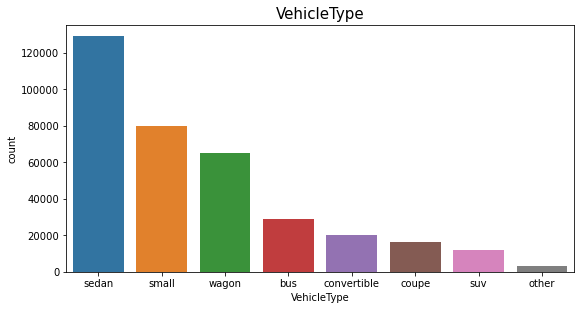

In [32]:
# barchart for categorical variable VehicleType
plt.figure(figsize=(20, 10))
plt.subplot(221)
sns.countplot(x='VehicleType', data=df_pd1, order=df_pd1['VehicleType'].value_counts().index)
plt.title('VehicleType', fontsize=15)
plt.show()

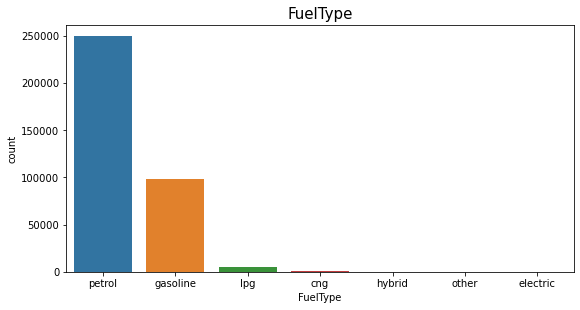

In [33]:
# barchart for categorical variable FuelType
plt.figure(figsize=(20, 10))
plt.subplot(221)
sns.countplot(x='FuelType', data=df_pd1, order=df_pd1['FuelType'].value_counts().index)
plt.title('FuelType', fontsize=15)
plt.show()

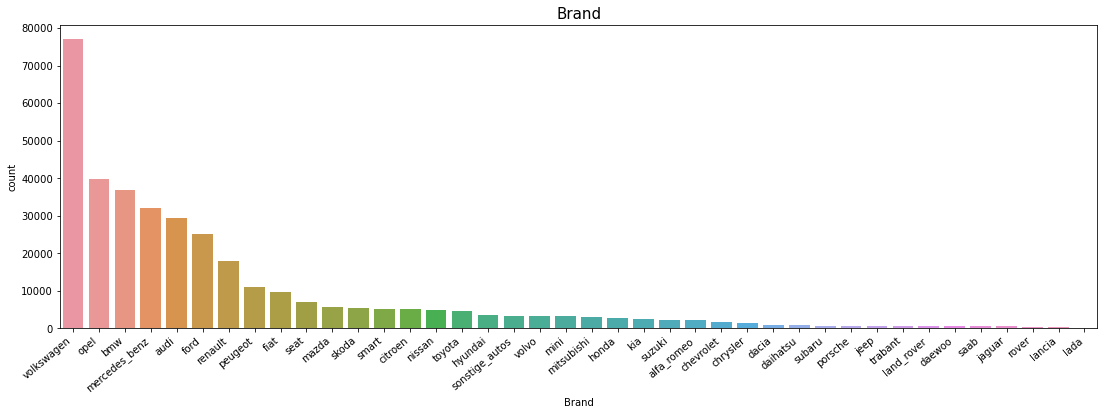

In [34]:
# barchart for categorical variable Brand
plt.figure(figsize=(30, 10))
plt.subplot(221)
ax = sns.countplot(x='Brand', data=df_pd1, order=df_pd1['Brand'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Brand', fontsize=15)
plt.show()

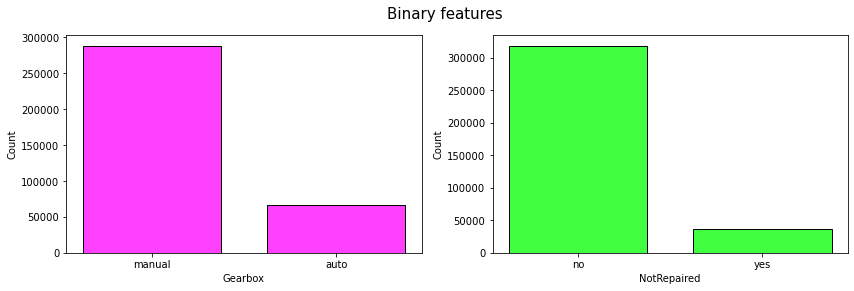

In [35]:
# barchart for categorical variables Gearbox and NotRepaired
fig1, axes = plt.subplots(1, 2, figsize=(14, 4))
fig1.suptitle('Binary features', fontsize=15) 
sns.histplot(ax=axes[0], data=df_pd1['Gearbox'], color='magenta', shrink=.75)
sns.histplot(ax=axes[1], data=df_pd1['NotRepaired'], color='lime', shrink=.75);

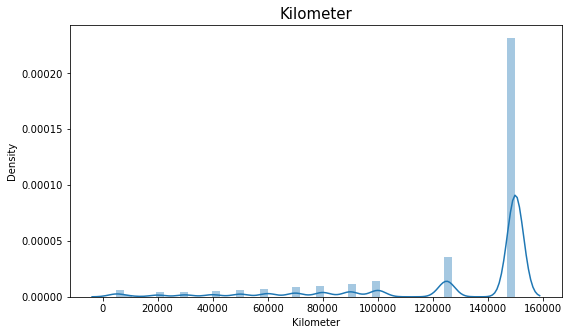

In [36]:
# distribusion of numerical variable Kilometer
plt.figure(figsize=(30, 5))
plt.subplot(131)
sns.distplot(df_pd1['Kilometer'])
plt.title('Kilometer', fontsize=15)
plt.show()

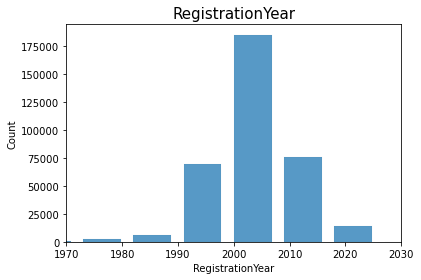

In [37]:
# distribusion of numerical variable RegistrationYear
fig2, ax2 = plt.subplots()
sns.histplot(df_pd1['RegistrationYear'], shrink=.75, bins=1000, ax=ax2)
ax2.set_xlim(1970, 2030)
plt.title('RegistrationYear', fontsize=15)
plt.show()

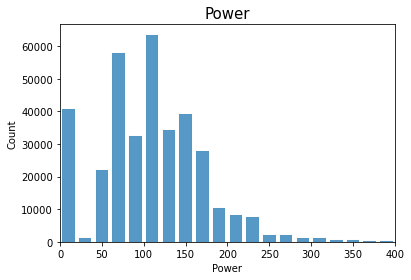

In [38]:
# distribusion of numerical variable Power
fig3, ax3 = plt.subplots()
sns.histplot(df_pd1['Power'], shrink=.75, bins=1000, ax=ax3)
ax3.set_xlim(0, 400)
plt.title('Power', fontsize=15)
plt.show()

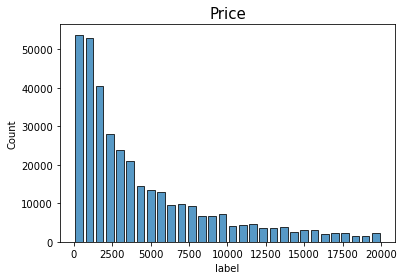

In [39]:
# distribusion of numerical variable Price
fig3, ax3 = plt.subplots()
sns.histplot(df_pd1['label'], shrink=.75, bins=30, ax=ax3)
# ax3.set_xlim(0, 400)
plt.title('Price', fontsize=15)
plt.show()

In [40]:
# define the threshold for insignificant categories
threshold1 = 97
threshold2 = 0.7

In [41]:
# function for replacing insignificant categories
def replace_cat(f, cols):
    # input are dataframe and categorical variables, 
    # replace insignificant categories (percentage <= 0.7) with largest number
    # of catgories and output is new dataframe
    
    # calculate the percentage and save it in Percent columns from each categories
    df_percent = f.groupBy(cols).count().sort(col('count').desc())\
                  .withColumn('total', sum(col('count')).over(window))\
                  .withColumn('Percent', col('count') * 100 / col('total')) 

    # calculate the highest percentage of category
    dominant_cat = df_percent.select(df_percent['Percent']).collect()[0][0] 
    
    # calculate distinct values in columns the highest percentage
    count_dist = f.select([cols]).distinct().count() 
    if count_dist > 2 and dominant_cat <= threshold1:
        print('column:', cols)
        cols_names.append(cols) # combine with previous list
        
        # define dominant category 
        replacement = f.groupBy(cols).count().sort(col('count').desc()).collect()[0][0] 
        print('replacement:', replacement)
        
        replacing.append(replacement) # combine with previous list
        insign_cat = df_percent.filter(
            df_percent['Percent'] < threshold2
            ).select(df_percent[cols]).collect() # calculate insignificant categories
        
        insign_cat = [r[cols] for r in insign_cat] # take the values
        category.append(insign_cat) # combine with previous list
        print('insign_cat:', insign_cat)
        
        # replace insignificant categories with dominant categories
        f = f.replace(insign_cat, replacement, cols) 
    return f

In [42]:
# # calculate the percentage and define it is of dominant category
# df_percent = df.groupBy('id').count().sort(col('count').desc())\
#                .withColumn('total', sum(col('count')).over(window))\
#                .withColumn('Percent', col('count') * 100 / col('total')) 
# dominant_cat = df_percent.select(df_percent['Percent']).collect()[0][0]
# dominant_cat

In [43]:
# call function replacing insignificant categories 
replacing = []
cols_names = []
category = []
for cols in cat_cols:
    df = replace_cat(df, cols)

column: VehicleType
replacement: sedan
insign_cat: []
column: Model
replacement: golf
insign_cat: ['octavia', 'fabia', 'cooper', 'clk', 'micra', '80', 'caddy', 'x_reihe', 'sharan', 'scenic', 'omega', 'laguna', 'civic', '1_reihe', 'leon', '6_reihe', 'i_reihe', 'slk', 'galaxy', 'tt', 'meriva', 'yaris', '7er', 'mx_reihe', 'kangoo', 'm_klasse', '500', 'escort', 'arosa', 'one', 's_klasse', 'vito', 'b_klasse', 'bora', 'colt', 'berlingo', 'beetle', 'tigra', 'v40', 'sprinter', 'transit', 'fox', 'z_reihe', 'swift', 'c_max', 'corolla', 'panda', 'seicento', 'tiguan', 'insignia', '4_reihe', 'v70', '156', 'primera', 'espace', 'scirocco', 'stilo', 'a1', 'touareg', 'almera', '147', 'avensis', 'grand', 'a5', 'qashqai', 'a8', 'eos', 'c3', 'signum', 'c5', 'c4', 'matiz', 'kaefer', '5_reihe', 'ducato', 's_max', 'agila', 'aygo', 'getz', '601', '100', 'combo', 'carisma', 'sl', 'cordoba', 'c2', 'c1', 'forfour', 'rio', 'jetta', 'cuore', 'a2', 'altea', 'superb', 'kadett', 'picanto', 'alhambra', 'accord', 'rav'

In [44]:
# check length in list cols_names, category and replacing
len(cols_names), len(category), len(replacing)

(4, 4, 4)

In [45]:
# print out data statistics
df_describe = df_pd1.describe()
df_describe

,label,RegistrationYear,Power,Kilometer,id
count,354369.00,354369.00,354369.00,354369.00,354369.00
mean,4416.66,2004.23,110.09,128211.17,177185.00
std,4514.16,90.23,189.85,37905.34,102297.66
min,0.00,1000.00,0.00,5000.00,1.00
25%,1050.00,1999.00,69.00,125000.00,88593.00
50%,2700.00,2003.00,105.00,150000.00,177185.00
75%,6400.00,2008.00,143.00,150000.00,265777.00
max,20000.00,9999.00,20000.00,150000.00,354369.00


In [46]:
# calculate quantile from pyspark dataframe, 0.05 is relativeError
quant = df.approxQuantile(num_cols, [0.25, 0.5, 0.75], 0.05)
quant

[[1999.0, 2003.0, 2007.0],
 [70.0, 102.0, 140.0],
 [125000.0, 150000.0, 150000.0]]

In [47]:
# convert to numpy array
quant_np = (np.array(quant).T).astype(int)
quant_np

array([[  1999,     70, 125000],
       [  2003,    102, 150000],
       [  2007,    140, 150000]])

In [49]:
# function for replacing outliers
def replce_outlier(data, col, q1, q3):

    IQR = q3 - q1             # calculate the value of IQR
    upper = q3 + (IQR * 1.5)  # calculate the value of upper side
    lower = q1 - (IQR * 1.5)  # calculate the value of lower side

    # replace outliers with mean value  
    data_updated = data.withColumn(
        col, 
        F.when(
            (data[col] > upper) | (data[col] < lower), 
            F.round(F.mean(col).over(Window.orderBy(F.lit(1)))).cast('int')
        ).otherwise(F.col(col))
    )
    return data_updated    

In [50]:
# # call function replacing outliers in numerical data
# for col, q1, q3 in zip(num_cols, quant_np[0], quant_np[2]):
#     df = replce_outlier(df, col, q1, q3)

In [51]:
# replace outliers in RegistrationYear
df = replce_outlier(df, num_cols[0], quant_np[0][0], quant_np[2][0])

In [52]:
# replace outliers in Power
df = replce_outlier(df, num_cols[1], quant_np[0][1], quant_np[2][1])

In [53]:
# find mean value in label column
label_avg_df = df.select(mean('label').alias('avg')).collect()
label_avg = int(label_avg_df[0]['avg'])
label_avg

4416

In [54]:
# replace small values (less than 100) in label with mean
df = df.withColumn('label', when(df['label'] < 100, label_avg).otherwise(df['label']))
df.select('label').where(df.label < 100).count()

0

In [55]:
# find mean value in Power column
power_avg_df = df.select(mean('Power').alias('avg')).collect()
power_avg = int(power_avg_df[0]['avg'])
power_avg

102

In [56]:
# replace small values in Power with mean
df = df.withColumn('Power', when(df['Power'] == 0, power_avg).otherwise(df['Power']))
df.select('Power').where(df.label == 0).count()

0

In [57]:
# assign new dataframe variable for vizualization
df_pd2 = df.toPandas()

In [58]:
# convert categorical data into category dtypes (for LightGBM)
for c in cat_cols:
    df_pd2[c] = df_pd2[c].astype('category')

In [59]:
# check for dtypes
df_pd2.dtypes

label                  int32
VehicleType         category
RegistrationYear       int32
Gearbox             category
Power                  int32
Model               category
Kilometer              int32
FuelType            category
Brand               category
NotRepaired         category
id                     int32
dtype: object

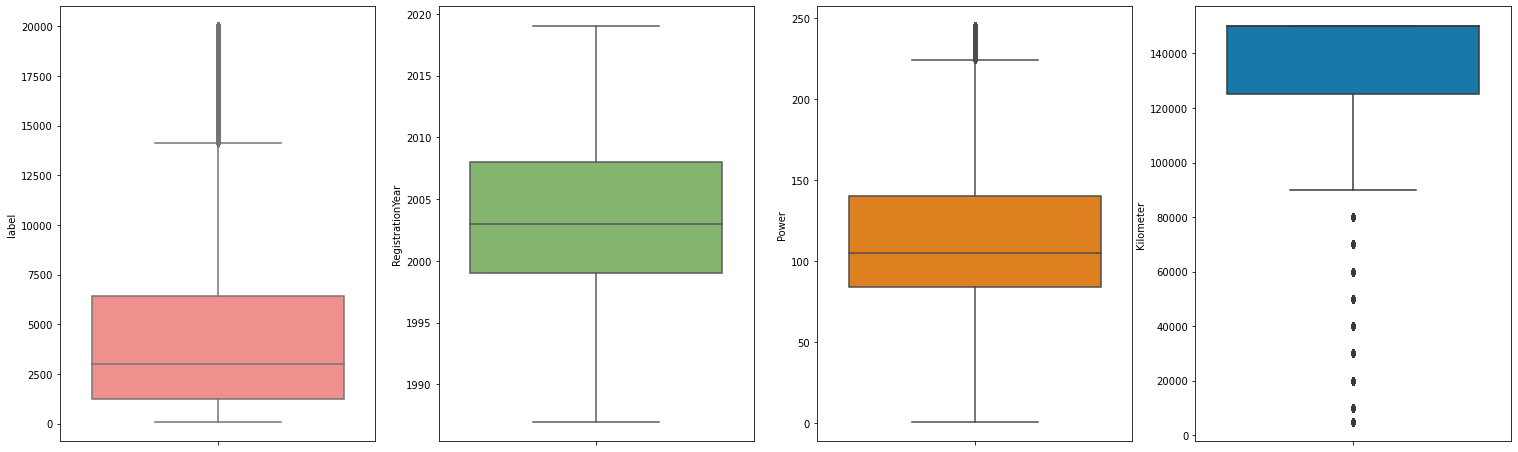

In [60]:
# check for outliers in numerical data
plt.figure(figsize=(26, 8))
plt.subplot(141)
sns.boxplot(y='label', data=df_pd2, palette='spring')
plt.subplot(142)
sns.boxplot(y='RegistrationYear', data=df_pd2, palette='summer')
plt.subplot(143)
sns.boxplot(y='Power', data=df_pd2, palette='autumn')
plt.subplot(144)
sns.boxplot(y='Kilometer', data=df_pd2, palette='winter')
plt.show()

In [61]:
# convert class column into numeric column
vehicle_indexer = StringIndexer(inputCol='VehicleType', outputCol='VehicleType_idx')
gear_indexer = StringIndexer(inputCol='Gearbox', outputCol='Gearbox_idx')
model_indexer = StringIndexer(inputCol='Model', outputCol='Model_idx')
fuel_indexer = StringIndexer(inputCol='FuelType', outputCol='FuelType_idx')
brand_indexer = StringIndexer(inputCol='Brand', outputCol='Brand_idx')
repair_indexer = StringIndexer(inputCol='NotRepaired', outputCol='NotRepaired_idx')

In [62]:
# convert numeric column into one-hot-encoded column
vehicle_vector = OneHotEncoder(inputCol='VehicleType_idx', outputCol='VehicleType_vec')
gear_vector = OneHotEncoder(inputCol='Gearbox_idx', outputCol='Gearbox_vec')
model_vector = OneHotEncoder(inputCol='Model_idx', outputCol='Model_vec')
fuel_vector = OneHotEncoder(inputCol='FuelType_idx', outputCol='FuelType_vec')
brand_vector = OneHotEncoder(inputCol='Brand_idx', outputCol='Brand_vec')
repair_vector = OneHotEncoder(inputCol='NotRepaired_idx', outputCol='NotRepaired_vec')

In [63]:
# create pipeline and pass all stages
pipeline = Pipeline(
    stages=[vehicle_indexer, gear_indexer, model_indexer, fuel_indexer, brand_indexer, repair_indexer,
            vehicle_vector, gear_vector, model_vector, fuel_vector, brand_vector, repair_vector
])

In [64]:
# transform dataframe
df_trans = pipeline.fit(df).transform(df)
df_trans = df_trans.drop(
    'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired',
    'VehicleType_idx', 'Gearbox_idx', 'Model_idx', 'FuelType_idx', 'Brand_idx', 'NotRepaired_idx'
)

In [65]:
# restore original name of columns
names_to_replace = [
    'VehicleType_vec', 'Gearbox_vec', 'Model_vec', 'FuelType_vec', 'Brand_vec', 'NotRepaired_vec'
]

for n, c in zip(names_to_replace, cat_cols):
    df_trans = df_trans.withColumnRenamed(n, c)

df_trans.show()       

+-----+----------------+-----+---------+---+-------------+-------------+---------------+-------------+---------------+-------------+
|label|RegistrationYear|Power|Kilometer| id|  VehicleType|      Gearbox|          Model|     FuelType|          Brand|  NotRepaired|
+-----+----------------+-----+---------+---+-------------+-------------+---------------+-------------+---------------+-------------+
|  480|            1993|  102|   150000|  1|(7,[0],[1.0])|(1,[0],[1.0])| (31,[0],[1.0])|(2,[0],[1.0])| (21,[0],[1.0])|(1,[0],[1.0])|
|18300|            2011|  190|   125000|  2|(7,[5],[1.0])|(1,[0],[1.0])| (31,[0],[1.0])|(2,[1],[1.0])| (21,[4],[1.0])|    (1,[],[])|
| 9800|            2004|  163|   125000|  3|(7,[6],[1.0])|    (1,[],[])| (31,[0],[1.0])|(2,[1],[1.0])| (21,[0],[1.0])|(1,[0],[1.0])|
| 1500|            2001|   75|   150000|  4|(7,[1],[1.0])|(1,[0],[1.0])| (31,[0],[1.0])|(2,[0],[1.0])| (21,[0],[1.0])|(1,[0],[1.0])|
| 3600|            2008|   69|    90000|  5|(7,[1],[1.0])|(1,[0],[1.0

In the process of statistical analysis of the data, work is carried out with the rarest values ​​for each of the categorical attributes. Those categories (classes) of objects, the percentage of which is less than 0.7 of the total, are replaced by the most frequently encountered category.

Numerical data is processed by calculating quantiles (IQR Interquartile range) and replacing rare values ​​with averages according to the distribution for each attribute.

To further build machine learning models, categorical data is encoded into numerical data using One-Hot-Encoder. As a result, each object takes the form `(n,[c],[1.0])`, where `n` is the number of categories, `[c]` is the category.

### Step 4. Machine learning models

In [66]:
# assemble and vectorize features
cols_assy = num_cols + cat_cols
assy = VectorAssembler(inputCols=cols_assy, outputCol='features')
df_assy = assy.transform(df_trans)
df_assy.printSchema()

root
 |-- label: integer (nullable = true)
 |-- RegistrationYear: integer (nullable = true)
 |-- Power: integer (nullable = true)
 |-- Kilometer: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- VehicleType: vector (nullable = true)
 |-- Gearbox: vector (nullable = true)
 |-- Model: vector (nullable = true)
 |-- FuelType: vector (nullable = true)
 |-- Brand: vector (nullable = true)
 |-- NotRepaired: vector (nullable = true)
 |-- features: vector (nullable = true)



In [67]:
# split data into train and test, train 70% and test 30%
data_train, data_test = df_assy.randomSplit([0.7, 0.3], 777)

In [68]:
# features and target (for LightGBM)
features_lgb = df_pd2.drop(['label', 'id'], axis=1) 
target_lgb = df_pd2['label'] 

In [69]:
# set aside 40% of train and validation data (for LightGBM)
X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(
    features_lgb, target_lgb, test_size=0.4, random_state=777
)

# use the same function above for the test set
X_val_lgb, X_test_lgb, y_val_lgb, y_test_lgb = train_test_split(
    X_val_lgb, y_val_lgb, test_size=0.5, random_state=777
)    

#### Linear Regression model

In [74]:
# create linear regression model to data train
lr_cross = LinearRegression(featuresCol='features', labelCol='label')

In [75]:
# hyper-parameter tuning
lr_param = ParamGridBuilder()\
    .addGrid(lr_cross.regParam, [0.1, 0.01])\
    .addGrid(lr_cross.elasticNetParam, [0.8, 0.7])\
    .build()

# cross-validation settings
lr_crossval = CrossValidator(
    estimator=lr_cross, 
    estimatorParamMaps=lr_param, 
    evaluator=RegressionEvaluator(metricName='rmse'), 
    numFolds=3,
    collectSubModels=True
)

In [76]:
# fit model to data train
lr_cross_start1 = time.time()
lr_cross_model = lr_crossval.fit(data_train)
lr_cross_end1 = time.time()
lr_cross_time1 = lr_cross_end1 - lr_cross_start1
print('Time elapsed for Linear Regression: {} sec'.format(lr_cross_time1))

Time elapsed for Linear Regression: 108.68521070480347 sec


In [77]:
# print out RMSE for every model
lr_cross_model.avgMetrics

[2890.7984555079265, 2890.797262318348, 2890.797250836816, 2890.800502426182]

In [78]:
# the best model
lr_cross_model.bestModel

LinearRegressionModel: uid=LinearRegression_25a4df6d0941, numFeatures=66

In [79]:
# print out the best RMSE
lr_cross_rmse = min(lr_cross_model.avgMetrics)
print('Root Mean Squared Error (RMSE): %g' % lr_cross_rmse)

Root Mean Squared Error (RMSE): 2890.8


In [80]:
# # make prediction on data test
# lr_cross_start2 = time.time()
# lr_cross_pred = lr_cross_model.transform(data_test)
# lr_cross_end2 = time.time()
# lr_cross_time2 = lr_cross_end2 - lr_cross_start2
# print('Time elapsed for Linear Regression with cross-valid: {} sec'.format(lr_cross_time2))

In [81]:
# # view label, prediction and feature from result of modelling
# lr_cross_pred.select('prediction', 'label', 'features').orderBy('id').show(5)

In [82]:
# # calculate RMSE
# lr_cross_rmse = RegressionEvaluator(metricName='rmse')
# lr_cross_rmse_print = lr_cross_rmse.evaluate(lr_cross_pred)
# print('Root Mean Squared Error (RMSE): %g' % lr_cross_rmse_print)

#### Decision Tree Regression model

In [83]:
# create Decision Tree Model
dt_cross = DecisionTreeRegressor(featuresCol='features', labelCol='label')

In [84]:
# hyper-parameter tuning
dt_param = ParamGridBuilder()\
    .addGrid(dt_cross.maxDepth, [5, 7])\
    .addGrid(dt_cross.maxBins, [10, 20])\
    .build()

# cross-validation settings   
dt_crossval = CrossValidator(
    estimator=dt_cross, 
    estimatorParamMaps=dt_param, 
    evaluator=RegressionEvaluator(metricName='rmse'), 
    numFolds=3, 
    collectSubModels=True
)

In [85]:
# fit model to data train
dt_cross_start1 = time.time()
dt_cross_model = dt_crossval.fit(data_train)
dt_cross_end1 = time.time()
dt_cross_time1 = dt_cross_end1 - dt_cross_start1
print('Time elapsed for Decision Tree with cross valid: {} sec'.format(dt_cross_time1))

Time elapsed for Decision Tree with cross valid: 135.09994983673096 sec


In [86]:
# the best model
dt_cross_model.bestModel

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_4dccdebbaa53, depth=7, numNodes=255, numFeatures=66

In [87]:
# print out RMSE for every model
dt_cross_model.avgMetrics

[2743.551113108819, 2665.53778443624, 2484.8310210527047, 2444.0519380695755]

In [88]:
# print out the best RMSE
dt_cross_rmse = min(dt_cross_model.avgMetrics)
print('Root Mean Squared Error (RMSE): %g' % dt_cross_rmse)

Root Mean Squared Error (RMSE): 2444.05


In [89]:
# # make prediction on data test
# dt_cross_start2 = time.time()
# dt_cross_pred = dt_cross_model.transform(data_test)
# dt_cross_end2 = time.time()
# dt_cross_time2 = dt_cross_end2 - dt_cross_start2
# print('Time elapsed for Decision Tree with cross valid: {} sec'.format(dt_cross_time2))

In [90]:
# # view prediction, label and featues from prediction
# dt_cross_pred.select('prediction', 'label', 'features').orderBy('id').show(5)

In [91]:
# # calculate RMSE
# dt_cross_rmse = RegressionEvaluator(metricName='rmse')
# dt_cross_rmse_print = dt_cross_rmse.evaluate(dt_cross_pred)
# print('Root Mean Squared Error (RMSE): %g' % dt_cross_rmse_print)

#### Random Forest Regression model

In [92]:
# create Random Forest Regression model
rf_cross = RandomForestRegressor(featuresCol='features', labelCol="label")

In [93]:
# hyper-parameter tuning
rf_param = ParamGridBuilder()\
    .addGrid(rf_cross.numTrees, [20, 40, 60])\
    .build()

# cross-validation settings    
rf_crossval = CrossValidator(
    estimator=rf_cross, 
    estimatorParamMaps=rf_param, 
    evaluator=RegressionEvaluator(metricName='rmse'), 
    numFolds=3,
    collectSubModels=True
) 

In [94]:
# fit model to data train
rf_cross_start1 = time.time()
rf_cross_model = rf_crossval.fit(data_train)
rf_cross_end1 = time.time()
rf_cross_time1 = rf_cross_end1 - rf_cross_start1
print('Time elapsed for Random Forest: {} sec'.format(rf_cross_time1))

Time elapsed for Random Forest: 253.93200182914734 sec


In [95]:
# the best model
rf_cross_model.bestModel

RandomForestRegressionModel: uid=RandomForestRegressor_3d3833b9d244, numTrees=40, numFeatures=66

In [96]:
# print out RMSE for every model
rf_cross_model.avgMetrics

[2621.568425886408, 2587.8985593271786, 2589.793975985772]

In [97]:
# print out the best RMSE
rf_cross_rmse = min(rf_cross_model.avgMetrics)
print('Root Mean Squared Error (RMSE): %g' % rf_cross_rmse)

Root Mean Squared Error (RMSE): 2587.9


In [98]:
# # make prediction on data test
# rf_cross_start2 = time.time()
# rf_cross_pred = rf_cross_model.transform(data_test)
# rf_cross_end2 = time.time()
# rf_cross_time2 = rf_cross_end2 - rf_cross_start2
# print('Time elapsed for Random Forest: {} sec'.format(rf_cross_time2))

In [99]:
# # view result of prediction, label, features
# rf_cross_pred.select('prediction', 'label', 'features').orderBy('id').show(5)

In [100]:
# # calculate RMSE
# rf_cross_rmse = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse')
# rf_cross_rmse_print = rf_cross_rmse.evaluate(rf_cross_pred)
# print('Root Mean Squared Error (RMSE): %g' % rf_cross_rmse_print)

#### Gradient Boosted Tree Regression model

In [101]:
# create Gradient Boosted Tree regression model
gbt_cross = GBTRegressor(featuresCol='features', labelCol='label')

In [102]:
# hyper-parameter tuning
gbt_param = ParamGridBuilder()\
    .addGrid(gbt_cross.maxIter, [10, 20])\
    .addGrid(gbt_cross.maxDepth, [5, 7, 10])\
    .build()

# cross-validation settings   
gbt_crossval = CrossValidator(
    estimator=gbt_cross, 
    estimatorParamMaps=gbt_param, 
    evaluator=RegressionEvaluator(metricName='rmse'), 
    numFolds=3,
    collectSubModels=True
)

In [103]:
# fit model to data train
gbt_cross_start1 = time.time()
gbt_cross_model = gbt_crossval.fit(data_train)
gbt_cross_end1 = time.time()
gbt_cross_time1 = gbt_cross_end1 - gbt_cross_start1
print('Time elapsed for Gradient Boosted Tree: {} sec'.format(gbt_cross_time1))

Time elapsed for Gradient Boosted Tree: 825.8823111057281 sec


In [104]:
# the best model
gbt_cross_model.bestModel

GBTRegressionModel: uid=GBTRegressor_32ea50ba7274, numTrees=20, numFeatures=66

In [105]:
# print out RMSE for every model
gbt_cross_model.avgMetrics

[2359.8413247175913,
 2172.422529877326,
 2032.4119315613812,
 2210.1449329907828,
 2093.0792883025993,
 1975.3684813365717]

In [106]:
# print out the best RMSE
gbt_cross_rmse = min(gbt_cross_model.avgMetrics)
print('Root Mean Squared Error (RMSE): %g' % gbt_cross_rmse)

Root Mean Squared Error (RMSE): 1975.37


In [107]:
# # make prediction on data test
# gbt_cross_start2 = time.time()
# gbt_cross_pred = gbt_cross_model.transform(data_test)
# gbt_cross_end2 = time.time()
# gbt_cross_time2 = gbt_cross_end2 - gbt_cross_start2
# print('Time elapsed for Gradient Boosted Tree with cross valid: {} sec'.format(gbt_basic_time2))

In [108]:
# # view result of prediction, label, features
# gbt_cross_pred.select('prediction', 'label', 'features').orderBy('id').show(5)

In [109]:
# # calculate RMSE
# gbt_cross_rmse = RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse')
# gbt_cross_rmse_print = gbt_cross_rmse.evaluate(gbt_cross_pred)
# print('Root Mean Squared Error (RMSE): %g' % gbt_cross_rmse_print)

#### Light Gradient Boosting Regression model

In [110]:
# create datasets for training
dtrain = lgb.Dataset(
    X_train_lgb, 
    y_train_lgb, 
    feature_name=cols_assy, 
    categorical_feature=cat_cols, 
    free_raw_data=False
)

deval = lgb.Dataset(
    X_val_lgb, 
    y_val_lgb, 
    feature_name=cols_assy, 
    categorical_feature=cat_cols, 
    reference=dtrain, 
    free_raw_data=False
)

In [111]:
# define hyper-parameters
params = {
    'task': 'train', 
    'objective': 'regression',
    'num_leaves': 20,
    'learning_rate': 0.01,
    'num_iterations': 5000,
    'metric': 'rmse',
    'verbose': -1,
    'random_state': 777 
}

In [112]:
# fit model to data train
lgb_cross_start1 = time.time()
lgb_cross_model = lgb.cv(
    params, 
    dtrain, 
    num_boost_round=100, 
    nfold=3, 
    stratified=False, 
    metrics='rmse', 
    seed=777,
    eval_train_metric=True
)
lgb_cross_end1 = time.time()
lgb_cross_time1 = lgb_cross_end1 - lgb_cross_start1
print('Time elapsed for Light Gradient Boosting: {} sec'.format(lgb_cross_time1))

Time elapsed for Light Gradient Boosting: 131.0341820716858 sec


In [113]:
# display results
lgb_cross_results = pd.DataFrame(lgb_cross_model).sort_values('valid rmse-mean').head(3)
lgb_cross_results

,train rmse-mean,train rmse-stdv,valid rmse-mean,valid rmse-stdv
4999,1696.51,1.13,1829.05,4.79
4998,1696.54,1.13,1829.05,4.79
4997,1696.56,1.13,1829.07,4.79


In [114]:
# print out the best RMSE
lgb_cross_rmse = lgb_cross_results.loc[4999, 'valid rmse-mean']
print('Root Mean Squared Error (RMSE): %g' % lgb_cross_rmse)

Root Mean Squared Error (RMSE): 1829.05


In [115]:
# fit the final model to data train
lgb_final_start1 = time.time()
lgb_final_model = lgb.train(
    params, 
    train_set=dtrain, 
    valid_sets=[dtrain, deval], 
    verbose_eval=params['num_iterations'] / 20
)
lgb_final_end1 = time.time()
lgb_final_time1 = lgb_final_end1 - lgb_final_start1
print('Time elapsed for Light Gradient Boosting: {} sec'.format(lgb_final_time1))

Time elapsed for Light Gradient Boosting: 40.489235401153564 sec


In [116]:
# make prediction on data test
lgb_final_start2 = time.time()
lgb_final_pred = lgb_final_model.predict(X_test_lgb)
lgb_final_end2 = time.time()
lgb_final_time2 = lgb_final_end2 - lgb_final_start2
print('Time elapsed for Light Gradient Boosting: {} sec'.format(lgb_final_time2))

Time elapsed for Light Gradient Boosting: 15.027421712875366 sec


In [117]:
# calculate RMSE of final model
lgb_final_mse = mean_squared_error(y_test_lgb, lgb_final_pred)
lgb_final_rmse = lgb_final_mse ** 0.5
print('Root Mean Squared Error (RMSE): %.2f' % lgb_final_rmse)

Root Mean Squared Error (RMSE): 1798.05


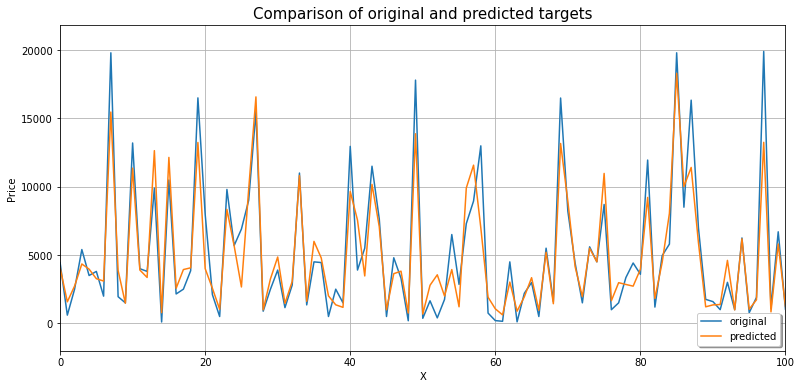

In [118]:
# visualize ML results
x_ax = range(len(y_test_lgb))
plt.figure(figsize=(13, 6))
plt.plot(x_ax, y_test_lgb, label='original')
plt.plot(x_ax, lgb_final_pred, label='predicted')
plt.title('Comparison of original and predicted targets', fontsize=15)
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.xlim([0, 100])
plt.show()  

In [119]:
# create dataframe with final results of cross-validation
results = {
        'ML model': [
            'Linear Rgression', 
            'Decision Tree',
            'Random Forest',
            'Gradient Boosted Tree',
            'Light Gradient Boosting'
        ], 
        'RMSE': [
            lr_cross_rmse, dt_cross_rmse, rf_cross_rmse, gbt_cross_rmse, lgb_cross_rmse
        ],
        'Time': [
            lr_cross_time1, dt_cross_time1, rf_cross_time1, gbt_cross_time1, lgb_cross_time1
        ],
}

display(pd.DataFrame(results).sort_values(by='RMSE').reset_index(drop=True))

,ML model,RMSE,Time
0,Light Gradient Boosting,1829.05,131.03
1,Gradient Boosted Tree,1975.37,825.88
2,Decision Tree,2444.05,135.10
3,Random Forest,2587.90,253.93
4,Linear Rgression,2890.80,108.69


### Conclusions

At the initial stage of the research, the original categorical and numerical data is processed using the PySpark libraries and visualized in Pandas. For the first type, rare values фку replaced with the most frequently repeated to improve the performance of the machine learning model. In order to exclude outliers, the numerical data is also processed by calculating the IQR and determining the upper and lower limits, beyond which the values ​​are replaced by average.

The main block presents several machine learning algorithms developed on PySpark and the additional LightGBM library together with Pandas and Sklearn. The results show that the most efficient model is Light Gradient Boosting with RMSE = 1829 and a total transformation and prediction time of about 131 seconds. In second place is Gradient Boosted Tree (RMSE = 1975), although the total time spent is significantly longer (about 825 seconds). The Decision Tree model is also below the declared accuracy threshold (RSME = 2444), while the time spent processing matrix operations is noticeably lower and amounts to 135 seconds.